# Exploration phase (**optional**)

In this exploration phase we will visualize some features of your dataset to help you make more informed decisitions in case you want to **adapt the default parameters** to your dataset.

You can always skip this part and go with the default parameters but if you want to have a classifier as efficient as possible you should consider spending five minutes running this analysis.

Processed 5851.jpg and applied settings


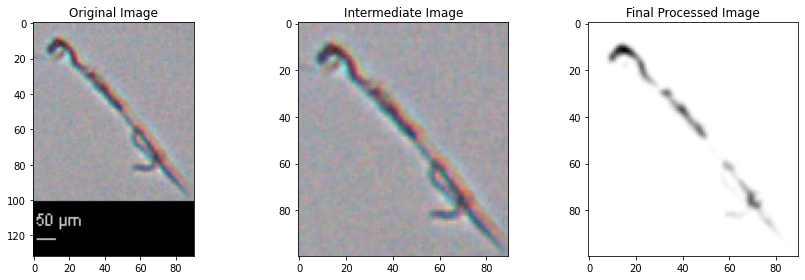

Processed 6164.jpg and applied settings


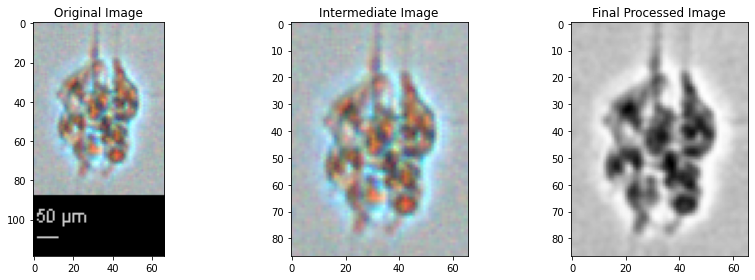

In [74]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Replace with your actual paths
original_images_folder = '/srv/phyto-plankton-classification/data/images/Actinoptychus'
new_images_folder = '/srv/phyto-plankton-classification/data/change_images/start'
output_folder = '/srv/phyto-plankton-classification/data/change_images/end'
intermediate_folder = '/srv/phyto-plankton-classification/data/change_images/middle'

# Adjustable Parameters
noise_std = 0
kernel_size = 3
threshold = 0.2

def apply_settings_to_image(image, brightness, contrast):
    # Adjust brightness and contrast
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image

def calculate_average_grayscale_stats(image_folder):
    image_files = os.listdir(image_folder)
    total_intensity = 0
    total_contrast = 0
    total_images = len(image_files)

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            total_intensity += np.mean(image)
            total_contrast += np.std(image)

    average_intensity = total_intensity / total_images
    average_contrast = total_contrast / total_images

    return average_intensity, average_contrast


def find_continuous_indices(arr, threshold_value, continuous_count):
    above_threshold = arr > threshold_value
    indices = np.where(above_threshold)[0]
    continuous_indices = []
    temp = []

    for idx in indices:
        if len(temp) == 0 or idx == temp[-1] + 1:
            temp.append(idx)
        else:
            temp = [idx]

        if len(temp) >= continuous_count:
            continuous_indices.extend(temp)
            
    return continuous_indices

def find_cropping_indices(indices_list, continuous_count):
    cropping_indices = []
    for i in range(len(indices_list) - continuous_count + 1):
        cropping_indices.append(indices_list[i:i+continuous_count])
    return cropping_indices

def remove_black_bars(image):
    threshold = 0.2
    row_sum = np.sum(image != 0, axis=1)
    col_sum = np.sum(image != 0, axis=0)

    continuous_count = 2

    bottom_cropping_indices = find_cropping_indices(find_continuous_indices(row_sum[::-1], threshold * image.shape[1], continuous_count), continuous_count)
    right_cropping_indices = find_cropping_indices(find_continuous_indices(col_sum[::-1], threshold * image.shape[0], continuous_count), continuous_count)

    max_bottom = 0
    max_right = 0

    for bottom_indices in bottom_cropping_indices:
        for right_indices in right_cropping_indices:
            bottom = image.shape[0] - bottom_indices[-1] if len(bottom_indices) > 0 else image.shape[0]
            right = image.shape[1] - right_indices[-1] if len(right_indices) > 0 else image.shape[1]

            if bottom > max_bottom:
                max_bottom = bottom
            if right > max_right:
                max_right = right

    cropped_image = image[:max_bottom, :max_right]
    return cropped_image

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Calculate original average grayscale stats
original_avg_brightness, original_avg_contrast = calculate_average_grayscale_stats(intermediate_folder)

# Process new images
new_image_files = os.listdir(new_images_folder)

for new_file in new_image_files:
    new_image_path = os.path.join(new_images_folder, new_file)
    new_color_image = cv2.imread(new_image_path)

    if new_color_image is None:
        print(f"Skipped {new_file} due to missing image")
        continue

    # Remove black bars
    cleaned_image = remove_black_bars(new_color_image)

    # Calculate brightness and contrast factors
    brightness_factor = original_avg_brightness / np.mean(cleaned_image)
    contrast_factor = original_avg_contrast / np.std(cleaned_image)

    # Calculate the average intensity of the new color image
    average_new_intensity = np.mean(cleaned_image)

    # Calculate the scaling factor based on the average intensities
    scaling_factor = original_avg_brightness / average_new_intensity

    # Adjust the intensity of the new color image
    adjusted_image = np.clip(cleaned_image * scaling_factor, 0, 255).astype(np.uint8)

    # Adjust brightness and contrast
    adjusted_image = apply_settings_to_image(adjusted_image, brightness_factor, contrast_factor)

    # Add noise
    noisy_image = adjusted_image + np.random.normal(0, noise_std, adjusted_image.shape).astype(np.uint8)

    # Apply blur
    blurred_image = cv2.GaussianBlur(noisy_image, (kernel_size, kernel_size), 0)

    # Convert the color image to grayscale
    grayscale_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Save the final processed image as grayscale
    output_path = os.path.join(output_folder, new_file)
    cv2.imwrite(output_path, grayscale_image)

    print(f"Processed {new_file} and applied settings")

    # Display the original, intermediate, and final images using Matplotlib
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(new_color_image)

    plt.subplot(132)
    plt.title('Intermediate Image')
    plt.imshow(cleaned_image)

    plt.subplot(133)
    plt.title('Final Processed Image')
    plt.imshow(grayscale_image, cmap='gray')

    plt.tight_layout()
    plt.show()


In [85]:
root_folder='/srv/phyto-plankton-classification/data/images/'
for subfolder_name in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder_name)
    if os.path.isdir(subfolder_path):
        image_files = os.listdir(subfolder_path)
        total_images += len(image_files)

NameError: name 'total_images' is not defined

In [84]:
subfolder_path

'/srv/phyto-plankton-classification/data/images/Actinoptychus/Actinoptychus_FFFD4F19-1A32-48C0-9FC5-370F5B1A3B5B_148947.jpg'

In [102]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# Replace with your actual paths
original_images_folder = '/srv/phyto-plankton-classification/data/images/'
new_images_folder = '/srv/phyto-plankton-classification/data/change_images/start/chaetoceros'
output_folder = '/srv/phyto-plankton-classification/data/change_images/end'
intermediate_folder = '/srv/phyto-plankton-classification/data/change_images/middle'

In [100]:

def apply_settings_to_image(image, brightness, contrast):
    # Adjust brightness and contrast
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image
def calculate_average_grayscale_stats(image_folder):
    image_files = os.listdir(image_folder)
    total_intensity = 0
    total_contrast = 0
    total_images = len(image_files)

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            total_intensity += np.mean(image)
            total_contrast += np.std(image)

    average_intensity = total_intensity / total_images
    average_contrast = total_contrast / total_images

    return average_intensity, average_contrast


def calculate_average_grayscale_stats(root_folder):
    total_intensity = 0
    total_contrast = 0
    total_images = 0

    for subfolder_name in tqdm(os.listdir(root_folder), desc='Subfolders'):
        subfolder_path = os.path.join(root_folder, subfolder_name)
        if os.path.isdir(subfolder_path):
            image_files = os.listdir(subfolder_path)
            total_images += len(image_files)

            for image_file in tqdm(image_files, desc='Images', leave=False):
                image_path = os.path.join(subfolder_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if image is not None:
                    total_intensity += np.mean(image)
                    total_contrast += np.std(image)

    average_intensity = total_intensity / total_images
    average_contrast = total_contrast / total_images

    return average_intensity, average_contrast


def find_continuous_indices(arr, threshold_value, continuous_count):
    above_threshold = arr > threshold_value
    indices = np.where(above_threshold)[0]
    continuous_indices = []
    temp = []

    for idx in indices:
        if len(temp) == 0 or idx == temp[-1] + 1:
            temp.append(idx)
        else:
            temp = [idx]

        if len(temp) >= continuous_count:
            continuous_indices.extend(temp)
            
    return continuous_indices

def find_cropping_indices(indices_list, continuous_count):
    cropping_indices = []
    for i in range(len(indices_list) - continuous_count + 1):
        cropping_indices.append(indices_list[i:i+continuous_count])
    return cropping_indices

def remove_black_bars(image,threshold):
    row_sum = np.sum(image != 0, axis=1)
    col_sum = np.sum(image != 0, axis=0)

    continuous_count = 2

    bottom_cropping_indices = find_cropping_indices(find_continuous_indices(row_sum[::-1], threshold * image.shape[1], continuous_count), continuous_count)
    right_cropping_indices = find_cropping_indices(find_continuous_indices(col_sum[::-1], threshold * image.shape[0], continuous_count), continuous_count)

    max_bottom = 0
    max_right = 0

    for bottom_indices in bottom_cropping_indices:
        for right_indices in right_cropping_indices:
            bottom = image.shape[0] - bottom_indices[-1] if len(bottom_indices) > 0 else image.shape[0]
            right = image.shape[1] - right_indices[-1] if len(right_indices) > 0 else image.shape[1]

            if bottom > max_bottom:
                max_bottom = bottom
            if right > max_right:
                max_right = right

    cropped_image = image[:max_bottom, :max_right]
    return cropped_image

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


original_avg_brightness, original_avg_contrast = calculate_average_grayscale_stats(original_images_folder)

original_avg_brightness, original_avg_contrast=154.78624500978557, 43.14511706175602

Subfolders:   0%|          | 0/98 [00:00<?, ?it/s]

Subfolders:   5%|▌         | 5/98 [00:14<04:37,  2.98s/it]


KeyboardInterrupt: 

In [90]:
original_avg_brightness, original_avg_contrast=154.78624500978557, 43.14511706175602

In [122]:
original_images_folder = '/srv/phyto-plankton-classification/data/images/'
new_images_folder = '/srv/phyto-plankton-classification/data/change_images/start/guinardia'
output_folder = '/srv/phyto-plankton-classification/data/change_images/end'
intermediate_folder = '/srv/phyto-plankton-classification/data/change_images/middle'

Processed gen1.jpg and applied settings


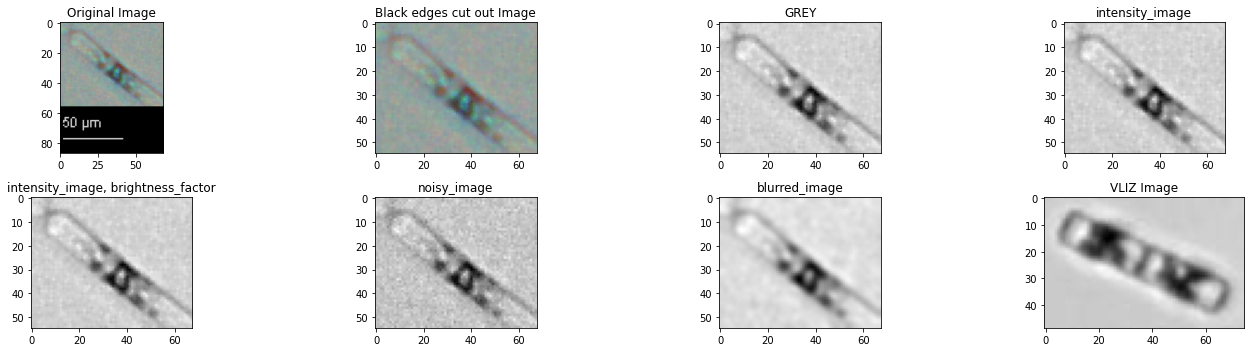

Processed gen2.jpg and applied settings


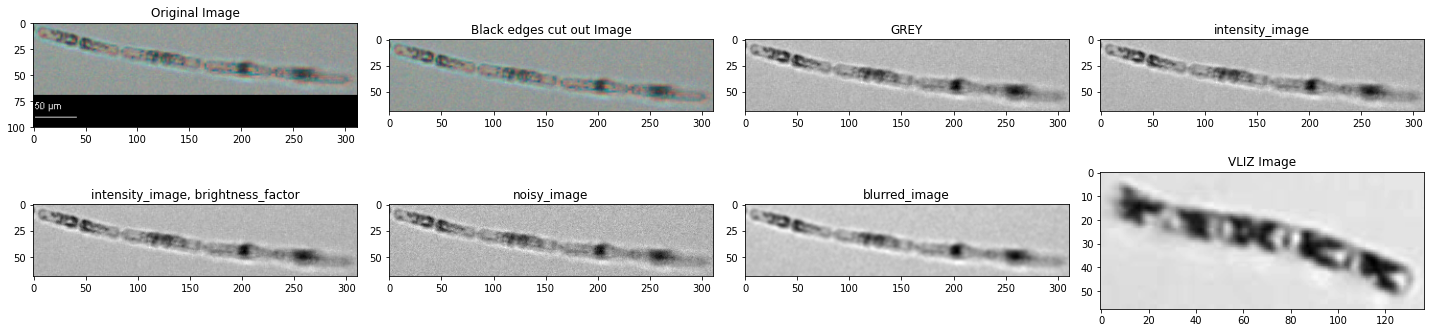

Processed gen3.jpg and applied settings


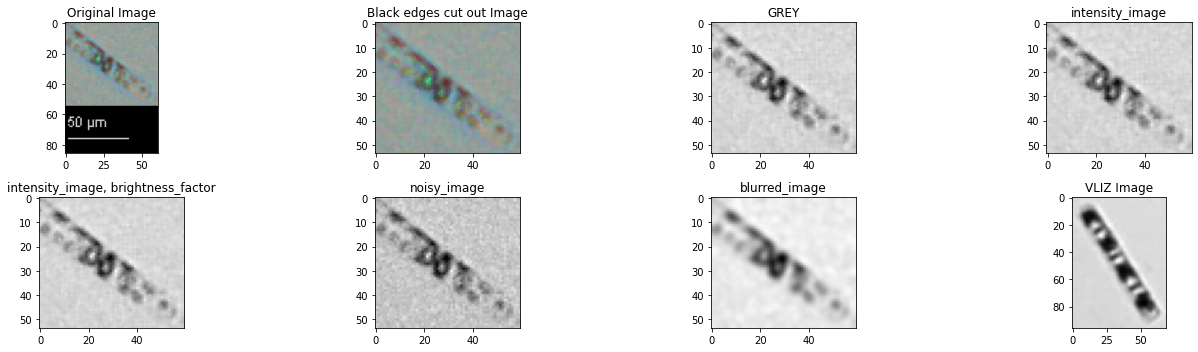

In [139]:
i=1
new_image_files = os.listdir(new_images_folder)
threshold=0.3
for new_file in new_image_files:
    new_image_path = os.path.join(new_images_folder, new_file)
    new_color_image = cv2.imread(new_image_path)

    if new_color_image is None:
        print(f"Skipped {new_file} due to missing image")
        continue

    # Remove black bars
    cleaned_image = remove_black_bars(new_color_image,threshold)

    # Convert the color image to grayscale
    grayscale_image = cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2GRAY)
    # Calculate the average intensity of the new color image
    average_new_intensity = np.mean(grayscale_image)

    # Calculate the scaling factor based on the average intensities
    scaling_factor = original_avg_brightness / average_new_intensity

    # Adjust the intensity of the new color image
    intensity_image = np.clip(grayscale_image * scaling_factor, 0, 255).astype(np.uint8)

    # Calculate brightness and contrast factors
    brightness_factor = original_avg_brightness / np.mean(intensity_image )
    contrast_factor = 1#original_avg_contrast / np.std(cleaned_image)

    # Adjust brightness and contrast
    adjusted_twice_image = apply_settings_to_image(intensity_image, brightness_factor, contrast_factor)

    # Add noise
    noise_std = 5
    noisy_image = adjusted_twice_image + np.random.normal(0, noise_std, adjusted_twice_image.shape).astype(np.uint8)

    # Apply blur
    kernel_size = 5
    blurred_image = cv2.GaussianBlur(noisy_image, (kernel_size, kernel_size), 0)



    # Save the final processed image as grayscale
    output_path = os.path.join(output_folder, new_file)
    cv2.imwrite(output_path, grayscale_image)

    print(f"Processed {new_file} and applied settings")

        # Display the original, intermediate, and final images using Matplotlib
    plt.figure(figsize=(20, 5))
    plt.subplot(241)
    plt.title('Original Image')
    plt.imshow(new_color_image)

    plt.subplot(242)
    plt.title('Black edges cut out Image')
    plt.imshow(cleaned_image)

    plt.subplot(243)
    plt.title('GREY')
    plt.imshow(grayscale_image, cmap='gray')

    plt.subplot(244)
    plt.title('intensity_image')
    plt.imshow(intensity_image, cmap='gray')

    plt.subplot(245)
    plt.title('intensity_image, brightness_factor')
    plt.imshow(adjusted_twice_image, cmap='gray')

    plt.subplot(246)
    plt.title('noisy_image')
    plt.imshow(noisy_image, cmap='gray')

    plt.subplot(247)
    plt.title('blurred_image')
    plt.imshow(blurred_image, cmap='gray')

    correct_image=f"/srv/phyto-plankton-classification/data/change_images/start/guinardia_vliz/gen{i}.jpg"
    i+=1
    vliz_image = cv2.imread(correct_image, cv2.IMREAD_GRAYSCALE)
    plt.subplot(248)
    plt.title('VLIZ Image')
    plt.imshow(vliz_image , cmap='gray')
    plt.tight_layout()
    plt.show()



In [120]:
correct_image=r"/srv/phyto-plankton-classification/data/change_images/start/chaetoceros_vliz/Guinardia_delicatula_00F547CD-B85C-4373-8552-35DA0C1B9D10_149112.jpg"
vliz_image = cv2.imread(correct_image, cv2.IMREAD_GRAYSCALE)
vliz_image

array([[140, 137, 131, ..., 181, 181, 181],
       [147, 144, 137, ..., 181, 181, 181],
       [157, 153, 148, ..., 181, 181, 181],
       ...,
       [177, 178, 178, ..., 181, 181, 181],
       [177, 178, 178, ..., 181, 181, 181],
       [177, 178, 178, ..., 181, 181, 181]], dtype=uint8)

TypeError: Image data of dtype object cannot be converted to float

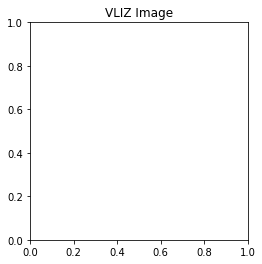

In [116]:
correct_image="/srv/phyto-plankton-classification/data/change_images/start/chaetoceros_vliz/Guinardia_delicatula_00F547CD-B85C-4373-8552-35DA0C1B9D10_149112.jpg"
vliz_image = cv2.imread(correct_image, cv2.IMREAD_GRAYSCALE)
plt.title('VLIZ Image')
plt.imshow(vliz_image , cmap='gray')
plt.tight_layout()
plt.show()

In [52]:
# Replace with your actual paths
original_images_folder = '/srv/phyto-plankton-classification/data/images/Actinoptychus'
new_images_folder = '/srv/phyto-plankton-classification/data/change_images/start'
output_folder = '/srv/phyto-plankton-classification/data/change_images/end'
intermediate_folder = '/srv/phyto-plankton-classification/data/change_images/middle'

In [66]:
def apply_settings_to_image(image, brightness, contrast):
    # Adjust brightness and contrast
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image
def calculate_average_grayscale_stats(image_folder):
    image_files = os.listdir(image_folder)
    total_intensity = 0
    total_contrast = 0
    total_images = len(image_files)

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            total_intensity += np.mean(image)
            total_contrast += np.std(image)

    average_intensity = total_intensity / total_images
    average_contrast = total_contrast / total_images

    return average_intensity, average_contrast

In [67]:
def find_continuous_indices(arr, threshold_value, continuous_count):
    above_threshold = arr > threshold_value
    indices = np.where(above_threshold)[0]
    continuous_indices = []
    temp = []

    for idx in indices:
        if len(temp) == 0 or idx == temp[-1] + 1:
            temp.append(idx)
        else:
            temp = [idx]

        if len(temp) >= continuous_count:
            continuous_indices.extend(temp)
            
    return continuous_indices

def find_cropping_indices(indices_list, continuous_count):
    cropping_indices = []
    for i in range(len(indices_list) - continuous_count + 1):
        cropping_indices.append(indices_list[i:i+continuous_count])
    return cropping_indices

def remove_black_bars(image):
    threshold = 0.2
    row_sum = np.sum(image != 0, axis=1)
    col_sum = np.sum(image != 0, axis=0)

    continuous_count = 2

    bottom_cropping_indices = find_cropping_indices(find_continuous_indices(row_sum[::-1], threshold * image.shape[1], continuous_count), continuous_count)
    right_cropping_indices = find_cropping_indices(find_continuous_indices(col_sum[::-1], threshold * image.shape[0], continuous_count), continuous_count)

    max_bottom = 0
    max_right = 0

    for bottom_indices in bottom_cropping_indices:
        for right_indices in right_cropping_indices:
            bottom = image.shape[0] - bottom_indices[-1] if len(bottom_indices) > 0 else image.shape[0]
            right = image.shape[1] - right_indices[-1] if len(right_indices) > 0 else image.shape[1]

            if bottom > max_bottom:
                max_bottom = bottom
            if right > max_right:
                max_right = right

    cropped_image = image[:max_bottom, :max_right]
    return cropped_image


In [ ]:

new_image_files = os.listdir(new_images_folder)

for new_file in new_image_files:
    new_image_path = os.path.join(new_images_folder, new_file)
    new_color_image = cv2.imread(new_image_path)

    if new_color_image is None:
        print(f"Skipped {new_file} due to missing image")
        continue

    # Remove black bars
    cleaned_image = remove_black_bars(new_color_image)

    # Calculate brightness and contrast factors
    brightness_factor = original_avg_brightness / np.mean(cleaned_image)
    contrast_factor = original_avg_contrast / np.std(cleaned_image)

    # Calculate the average intensity of the new color image
    average_new_intensity = np.mean(cleaned_image)

    # Calculate the scaling factor based on the average intensities
    scaling_factor = original_avg_brightness / average_new_intensity

    # Adjust the intensity of the new color image
    adjusted_image = np.clip(cleaned_image * scaling_factor, 0, 255).astype(np.uint8)

    # Adjust brightness and contrast
    #adjusted_image = apply_settings_to_image(adjusted_image, brightness_factor, contrast_factor)

    # Add noise
    noise_std = 0
    noisy_image = adjusted_image + np.random.normal(0, noise_std, adjusted_image.shape).astype(np.uint8)

    # Apply blur
    kernel_size = 3
    blurred_image = cv2.GaussianBlur(noisy_image, (kernel_size, kernel_size), 0)

    # Convert the color image to grayscale
    grayscale_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Save the final processed image as grayscale
    output_path = os.path.join(output_folder, new_file)
    cv2.imwrite(output_path, grayscale_image)

    print(f"Processed {new_file} and applied settings")

        # Display the original, intermediate, and final images using Matplotlib
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(new_color_image)

    plt.subplot(132)
    plt.title('Intermediate Image')
    plt.imshow(cleaned_image)

    plt.subplot(133)
    plt.title('Final Processed Image')
    plt.imshow(grayscale_image, cmap='gray')

    plt.tight_layout()
    plt.show()



Processed 5851.jpg and applied settings


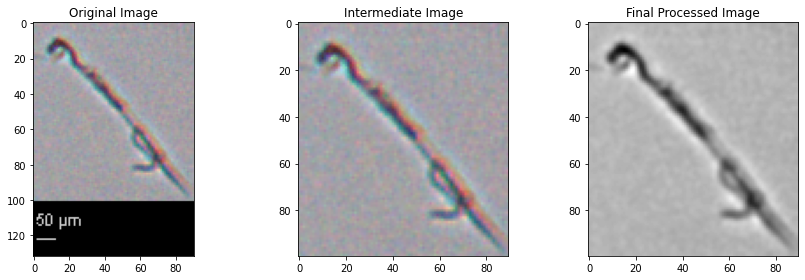

Processed 6164.jpg and applied settings


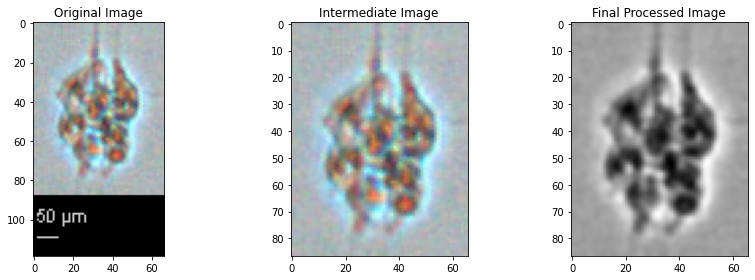

In [72]:

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

original_avg_brightness, original_avg_contrast = calculate_average_grayscale_stats(intermediate_folder)


new_image_files = os.listdir(new_images_folder)

for new_file in new_image_files:
    new_image_path = os.path.join(new_images_folder, new_file)
    new_color_image = cv2.imread(new_image_path)

    if new_color_image is None:
        print(f"Skipped {new_file} due to missing image")
        continue

    # Remove black bars
    cleaned_image = remove_black_bars(new_color_image)

    # Calculate brightness and contrast factors
    brightness_factor = original_avg_brightness / np.mean(cleaned_image)
    contrast_factor = original_avg_contrast / np.std(cleaned_image)

    # Calculate the average intensity of the new color image
    average_new_intensity = np.mean(cleaned_image)

    # Calculate the scaling factor based on the average intensities
    scaling_factor = original_avg_brightness / average_new_intensity

    # Adjust the intensity of the new color image
    adjusted_image = np.clip(cleaned_image * scaling_factor, 0, 255).astype(np.uint8)

    # Adjust brightness and contrast
    #adjusted_image = apply_settings_to_image(adjusted_image, brightness_factor, contrast_factor)

    # Add noise
    noise_std = 0
    noisy_image = adjusted_image + np.random.normal(0, noise_std, adjusted_image.shape).astype(np.uint8)

    # Apply blur
    kernel_size = 3
    blurred_image = cv2.GaussianBlur(noisy_image, (kernel_size, kernel_size), 0)

    # Convert the color image to grayscale
    grayscale_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Save the final processed image as grayscale
    output_path = os.path.join(output_folder, new_file)
    cv2.imwrite(output_path, grayscale_image)

    print(f"Processed {new_file} and applied settings")

        # Display the original, intermediate, and final images using Matplotlib
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(new_color_image)
    
    plt.subplot(132)
    plt.title('Intermediate Image')
    plt.imshow(cleaned_image)
    
    plt.subplot(133)
    plt.title('Final Processed Image')
    plt.imshow(grayscale_image, cmap='gray')
    
    plt.tight_layout()
    plt.show()


In [63]:
contrast_factor

0.2887727189468553

In [61]:
original_avg_brightness

167.76276988860113

In [62]:
np.mean(new_image)

131.47108992850872

In [15]:
import os

import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

import planktonclas
from planktonclas import paths, config
from planktonclas.data_utils import load_image, load_data_splits, augment, load_class_names


CONF = config.get_conf_dict()

# Customize your image folder if needed
# CONF['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets'  # absolute path to image_folder

splits_dir = paths.get_splits_dir()

# Load the training data
X_train, y_train = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='train')

# Load the validation data
if (CONF['training']['use_validation']) and ('val.txt' in os.listdir(splits_dir)):
    X_val, y_val = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='val')
else:
    print('No validation data.')
    X_val, y_val = None, None
    CONF['training']['use_validation'] = False
    
# Load the class names
class_names = load_class_names(splits_dir=splits_dir)

Loading train data...
Loading val data...
Loading class names...


In [16]:
X_train

array(['data/images/Bellerochea_horologicalis/Bellerochea_horologicalis_55DAB8E5-D622-4A61-92AE-74342576738A_447730.jpg',
       'data/images/Bacillariophyceae_type1_colony/Bacillariophyceae_type1_colony_166A402E-9485-44BC-ACC9-EEFB3099378D_148899.jpg',
       'data/images/Stephanopyxis/Stephanopyxis_4DA1122C-B77B-4E9A-AF4E-E017CBC4F553_149630.jpg',
       ...,
       'data/images/Zygoceros/Zygoceros_945B1B05-BA2B-461F-A18A-E6FC18B6A495_162969.jpg',
       'data/images/Detritus/Detritus_4A45DD49-F1E0-4E1C-A8C8-8ACB66516FDB_Detritus.jpg',
       'data/images/Chaetoceros/Chaetoceros_AEE336BB-F825-46BD-B9F6-58122414C28B_148985.jpg'],
      dtype='<U179')

In [13]:
CONF['general']['images_directory']

'data/images'

In [5]:
paths.get_splits_dir()

'/srv/phyto-plankton-classification/data/dataset_files'

In [3]:
import os
import threading
from multiprocessing import Pool
import queue
import subprocess
import warnings
import base64

import numpy as np
import requests
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical, Sequence
import cv2
import albumentations
from albumentations.augmentations import transforms
from albumentations.imgaug import transforms as imgaug_transforms

## 1.1 Distribution of classes
**Relevant parameters:** `use_class_weights`

We can visualize the distributions of the classes to check is the dataset is highly imbalanced.

In [17]:
y_train

array([11,  9, 79, ..., 97, 31, 19], dtype=int32)

In [9]:
ax=axs[1]
n, bins, patches = ax.hist(y_train, bins=len(class_names), log=log_scale)

In [18]:
bins

array([ 0.        ,  0.98850575,  1.97701149,  2.96551724,  3.95402299,
        4.94252874,  5.93103448,  6.91954023,  7.90804598,  8.89655172,
        9.88505747, 10.87356322, 11.86206897, 12.85057471, 13.83908046,
       14.82758621, 15.81609195, 16.8045977 , 17.79310345, 18.7816092 ,
       19.77011494, 20.75862069, 21.74712644, 22.73563218, 23.72413793,
       24.71264368, 25.70114943, 26.68965517, 27.67816092, 28.66666667,
       29.65517241, 30.64367816, 31.63218391, 32.62068966, 33.6091954 ,
       34.59770115, 35.5862069 , 36.57471264, 37.56321839, 38.55172414,
       39.54022989, 40.52873563, 41.51724138, 42.50574713, 43.49425287,
       44.48275862, 45.47126437, 46.45977011, 47.44827586, 48.43678161,
       49.42528736, 50.4137931 , 51.40229885, 52.3908046 , 53.37931034,
       54.36781609, 55.35632184, 56.34482759, 57.33333333, 58.32183908,
       59.31034483, 60.29885057, 61.28735632, 62.27586207, 63.26436782,
       64.25287356, 65.24137931, 66.22988506, 67.2183908 , 68.20

In [19]:
n

array([ 885.,  176.,  228.,  159., 8000.,  159., 2414., 4562., 2215.,
       2591., 8000.,  174., 8000.,  154., 1802., 8000.,  169., 8000.,
         92., 1736.,  962.,  138.,  541.,  471.,   79.,  237.,  182.,
       5838., 8000., 1699.,  281.,  144., 8000., 8000., 3165.,  800.,
        465., 8000., 3392., 8000., 6137., 4703., 4795., 8000.,  211.,
        859., 8000.,  347.,  605., 6672.,  704.,  326., 2625.,  143.,
       3102., 8000.,  542., 8000.,  643.,  119.,  209.,  129.,  593.,
       3003., 8000., 8000., 8000.,  158., 1268.,  310., 4511.,  693.,
       5080., 1708.,  331., 2041., 8000., 4495.,  308.,  729.,  291.,
        451.,  354.,  903., 5113.,  971.,  157.])

Max Training: 8060.0
Min Training: 9.0
Mean Training: 2529.0102040816328
Median Training: 689.5


Max Validation: 1054.0
Min Validation: 1.0
Mean Validation: 316.1326530612245
Median Validation: 91.0




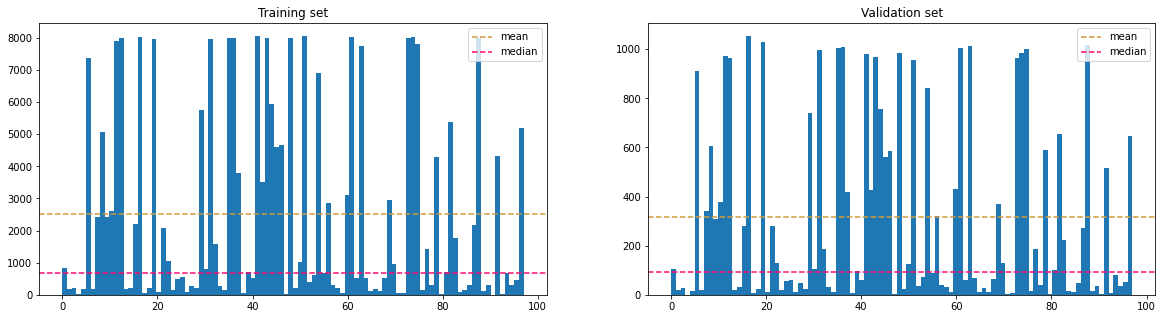

In [20]:
# Define some parameters
log_scale = False
show_names = False

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(20,5))

def plot_hist(ax, y, set_name=''):
    n, bins, patches = ax.hist(y, bins=len(class_names), log=log_scale)
    mean, med = np.mean(n), np.median(n)
    ax.axhline(mean, linestyle= '--', color='#ce9b3b', label='mean')
    ax.axhline(med, linestyle= '--', color='#fc0c70', label='median')
    ax.set_title('{} set'.format(set_name))
    ax.legend()
    if show_names:
        ax.set_xticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation='vertical')

    print('Max {}: {}'.format(set_name, np.amax(n)))
    print('Min {}: {}'.format(set_name, np.amin(n)))
    print('Mean {}: {}'.format(set_name, mean))
    print('Median {}: {}'.format(set_name, med))
    print('\n')

plot_hist(axs[0], y_train, set_name='Training')

axs[1].set_title('Validation set')
if y_val is not None:
    plot_hist(axs[1], y_val, set_name='Validation')

So if your dataset is **very** imbalanced you can consider setting the `use_class_weights` to `True` to compensate for this imbalance during the training.

## 1.2 Distribution of image sizes
**Relevant parameters:** `im_size`

We can visualize how the sizes of your images are tipically distributed in case you want to use a bigger image size resolution than the default.

In [56]:
# Load all images and retrieve their shapes
height, width = [], []
for img_path in tqdm(X_train):
    img = load_image(img_path)
    w, h, channels = img.shape
    width.append(w)
    height.append(h)

100%|██████████| 246249/246249 [29:24<00:00, 139.58it/s]


Max Heights: 987
Min Heights: 9
Mean Heights: 83.7
Median Heights: 70.0
Heights 5th percentile: 25.0


Max Widths: 964
Min Widths: 11
Mean Widths: 107.7
Median Widths: 87.0
Widths 5th percentile: 47.0


Max Combined: 987
Min Combined: 9
Mean Combined: 95.7
Median Combined: 78.0
Combined 5th percentile: 32.0




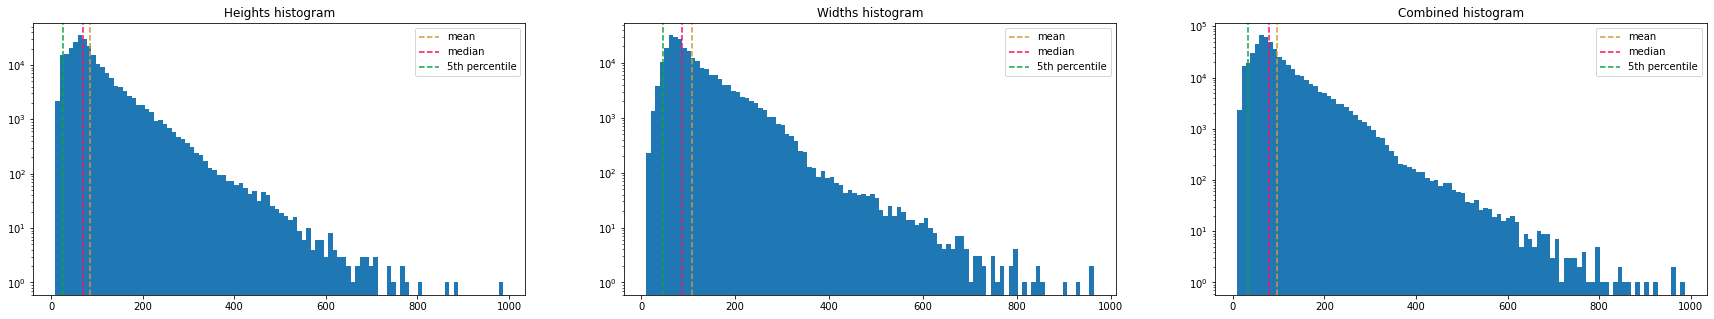

In [57]:
# Define some parameters
bins = 100
log_scale = True
lower_percentile = 5

def plot_hist(ax, values, set_name=''):
    
    # Print some stats
    mean, med, per = np.mean(values), np.median(values), np.percentile(values, lower_percentile)

    print('Max {}: {}'.format(set_name, np.amax(values)))
    print('Min {}: {}'.format(set_name, np.amin(values)))
    print('Mean {}: {:.1f}'.format(set_name, mean))
    print('Median {}: {}'.format(set_name, med))
    print('{} {}th percentile: {}'.format(set_name, lower_percentile, per))
    print('\n')
      
    # Plot the histogram
    ax.hist(values, bins=bins, log=log_scale)
    ax.set_title('{} histogram'.format(set_name))
    ax.axvline(mean, linestyle= '--', color='#ce9b3b', label='mean')
    ax.axvline(med, linestyle= '--', color='#fc0c70', label='median')
    ax.axvline(per, linestyle= '--', color='#0ea541', label='{}th percentile'.format(lower_percentile))
    ax.legend()

    
fig, axs = plt.subplots(1, 3, figsize=(30,5))
axs = axs.flatten()

plot_hist(axs[0], height, set_name='Heights')
plot_hist(axs[1], width, set_name='Widths')
plot_hist(axs[2], height + width, set_name='Combined')

So after examining these plots and stats you can consider adapting the parameter `im_size` to better suit your usecase (maybe to a value in between the `Min combined` and the `Combined 5th percentile`).

When **increasing** this parameter from the default value you have to consider that:
* you keep more details in the image so the accuracy of the model *might* (or might not) increase.
* bigger images size means longer training and inference times
* bigger images means more model parameters. So it is possible to that model becomes too big to be trained on a GPU. 

## 1.3 Data augmentation
**Relevant parameters:** `aug_params`

Let's visualize if the default parameters of the data augmentation suit our dataset (and change them if needed)


    Perform data augmentation on some image using the albumentations package.

    Parameters
    ----------
    im : Numpy array
    params : dict or None
        Contains the data augmentation parameters
        Mandatory keys:
        - h_flip ([0,1] float): probability of performing an horizontal left-right mirroring.
        - v_flip ([0,1] float): probability of performing an vertical up-down mirroring.
        - rot ([0,1] float):  probability of performing a rotation to the image.
        - rot_lim (int):  max degrees of rotation.
        - stretch ([0,1] float):  probability of randomly stretching an image.
        - crop ([0,1] float): randomly take an image crop.
        - zoom ([0,1] float): random zoom applied to crop_size.
            --> Therefore the effective crop size at each iteration will be a
                random number between 1 and crop*(1-zoom). For example:
                  * crop=1, zoom=0: no crop of the image
                  * crop=1, zoom=0.1: random 

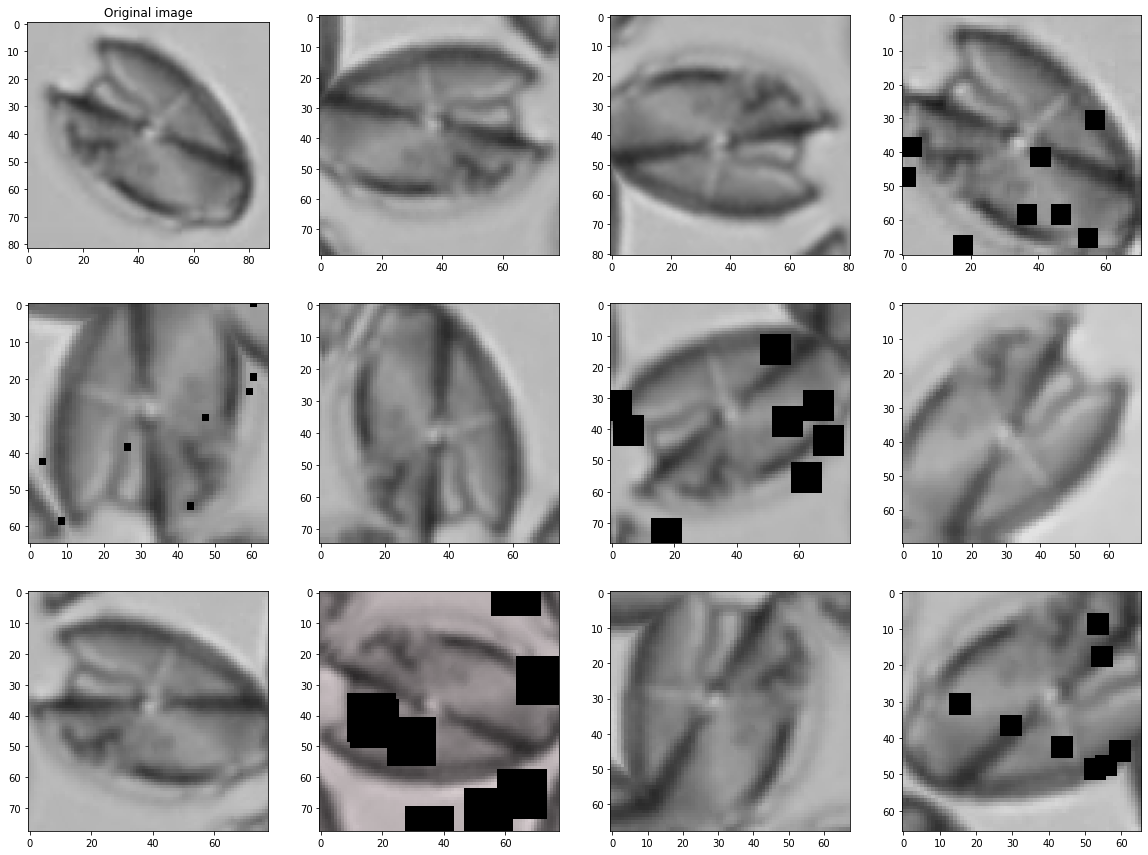

In [58]:
# Select the augmentation type
aug_params = CONF['augmentation']['train_mode'] #you can also try 'test_mode'

# You can also use your custom parameter to try different augmentations
aug_params = {'h_flip': 0.5,
              'v_flip': 0.5,
              'rot': 0.7,
              'rot_lim': 90,
              'stretch': 0.,
              'crop': 1.0,
              'zoom': 0.2,
              'blur': 0.3,
              'pixel_noise': 0.3,
              'pixel_sat': 0.3,
              'cutout': 0.5}

print(augment.__doc__)

fig, axs = plt.subplots(3,4, figsize=(20,15))
axs = axs.flatten()

# Plot original image
img = load_image(X_train[0])
axs[0].imshow(np.array(img).astype(np.uint8))
axs[0].set_title('Original image')

# Plot different examples of data augmentation
for i in range(11):
    img_aug = augment(img, params=aug_params)
    axs[i+1].imshow(np.array(img_aug).astype(np.uint8))